# Cell counting task


On this task we have:

- Input: 200 cell images of 256x256
- Output: 200 label images of 256x256


Our task is:

1.   Read the data and split it to train and test
2.   Prepare the labels
3.   Define the network
4.   Train the network


We aim to achive minimal MAE (Mean Absolute Error):



```
MAE = np.sum(np.abs(targets.detach().numpy() - yhat.detach().numpy()))/len(targets.detach().numpy())
```




### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from __future__ import print_function, division

%matplotlib inline

import numpy as np
np.random.seed(317)  # Set the random seed

import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets, models, transforms

import copy

import os
from PIL import Image
from google.colab import drive


import matplotlib.image as mpimg
import scipy.misc


import re


!pip install torchsummary
from torchsummary import summary

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Preprocess

In [3]:
def plot_convergence(dict_res, num_epochs):
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  types=['Loss', 'Accuracy']
  plt.subplot(1,2,1); plt.plot(dict_res['train'][0]); plt.plot(dict_res['val'][0]); plt.title('Loss'); plt.legend(['train','val'])
  plt.subplot(1,2,2); plt.plot(dict_res['train'][1]); plt.plot(dict_res['val'][1]); plt.title('Accuracy'); plt.legend(['train','val'])


### Load the data

Loading the images

Mounted at /content/drive/
Images shape: (200, 256, 256, 3)
image_names shape: (200,)


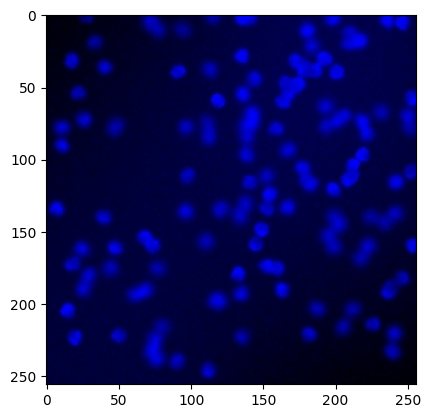

001


In [4]:

drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Colab Notebooks/NN/data/images'

images = []
image_names = []

for file in os.listdir(path):
    if file.endswith(".png"):
        image = Image.open(os.path.join(path, file)).resize((256, 256))
        # Convert to RGB if the image is grayscale
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = np.array(image)
        # Normalize the image
        image = image / 255.0
        # Transpose the array to make it compatible with PyTorch
        images.append(image)
        image_names.append(file)

images = np.array(images)

# Processing the image names
image_names = [re.search(r'\d+', text).group() for text in image_names]
image_names = np.array(image_names)

images_with_names = dict(zip(image_names, images))

print("Images shape:", images.shape)
print("image_names shape:", image_names.shape)

# Printing the first image
img = images[0]
plt.imshow(img); plt.show()
print(image_names[0])


labels shape: (200, 256, 256, 3)
labels_name shape: (200,)


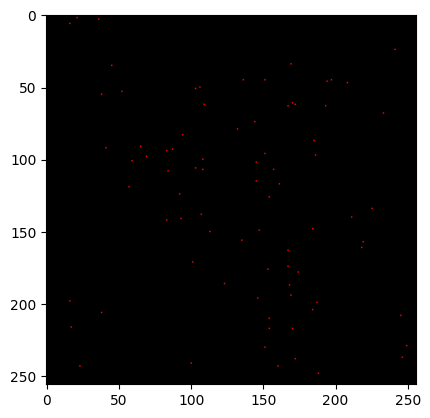

003 82


In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/NN/data/labels'

labels = []
labels_name = []

# Collecting the labels
for file in os.listdir(path):
    if file.endswith(".png"):
        image = Image.open(os.path.join(path, file)).resize((256, 256))
        image = np.array(image)
        labels.append(image)
        labels_name.append(file)

labels = np.array(labels)

# Process the label names
labels_name = [re.search(r'\d+', text).group() for text in labels_name]
labels_name = np.array(labels_name)

# create a lable, we predict 1 number, use L2 loss
labels_cnt = [int((label/255).sum()) for label in labels]

labels_with_names = dict(zip(labels_name, labels_cnt))
labels_img_with_names = dict(zip(labels_name, labels))

print("labels shape:", labels.shape)
print("labels_name shape:", labels_name.shape)

img = labels[0]
plt.imshow(img); plt.show()
print(labels_name[0], labels_cnt[0])

## CustomDataset(Dataset)

Creating a CustomDataset class for images and labels

In [6]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.class_names = [int(label) for label in self.labels.values()] #list(self.labels.values())
        self.file_names = list(self.images.keys())
        self.transform = transform

    def __len__(self):
        return len(self.class_names)

    def __getitem__(self, idx):
        name = self.file_names[idx]
        label = self.labels[name]
        img = self.images[name]
        if self.transform:
            img = self.transform(img)
        return img, label

    @property
    def classes(self):
        return self.class_names


Printing one image using the CustomDataset class

<class 'dict'>
135


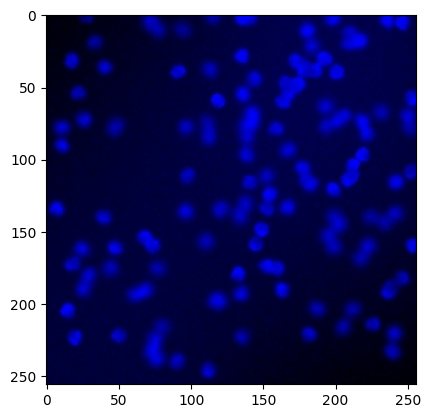

In [7]:
test = CustomDataset(images_with_names, labels_with_names)
print(type(test.images))
#print(test.images.keys())

plt.imshow(test.images['001'])
print(test.labels['001'])

## Dataloaders

Defining the dataloaders

In [8]:
# choose which items will be in train set:
# np.random.seed(317)
# train_labels =  np.random.choice(image_names, size=180, replace=False, )

# last 20 items - are the validation set
val_labels = [str(k) for k in range(181,201)]

images_train = {k: v for k, v in images_with_names.items() if k not in val_labels}
labels_train = {k: v for k, v in labels_with_names.items() if k not in val_labels}

images_test = {k: v for k, v in images_with_names.items() if k in val_labels}
labels_test = {k: v for k, v in labels_with_names.items() if k in val_labels}

# Defining the mean and STD for the image normalization
mean = np.array(list(images_train.values())).mean(axis=0).mean(axis=(0,1))
std = np.array(list(images_train.values())).std(axis=0).std(axis=(0,1))

data_transforms = transforms.Compose([
    transforms.ToTensor()
    ,transforms.Normalize(mean, std)
])

image_datasets = {'train': CustomDataset(images_train, labels_train, transform=data_transforms),
                  'val': CustomDataset(images_test, labels_test, transform=data_transforms)}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=1,
                                             shuffle=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=1,
                                          shuffle=False)
  }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

class_names = image_datasets['train'].classes
print('class_names:', class_names)



dataset_sizes:  {'train': 180, 'val': 20}
class_names: [82, 135, 233, 96, 86, 143, 169, 199, 195, 197, 241, 196, 168, 112, 122, 223, 200, 97, 158, 111, 255, 168, 78, 146, 155, 117, 190, 183, 301, 115, 315, 223, 142, 198, 280, 129, 228, 126, 136, 117, 89, 159, 225, 238, 137, 197, 212, 178, 208, 192, 186, 83, 202, 181, 162, 122, 111, 206, 154, 206, 242, 255, 250, 103, 93, 198, 241, 155, 212, 191, 230, 219, 218, 173, 214, 192, 264, 104, 175, 231, 164, 96, 145, 100, 251, 258, 179, 278, 269, 244, 314, 168, 187, 193, 134, 108, 126, 220, 254, 156, 121, 200, 252, 242, 211, 194, 257, 147, 295, 306, 199, 78, 221, 92, 116, 102, 237, 130, 139, 112, 207, 104, 207, 277, 144, 257, 129, 74, 98, 162, 74, 98, 208, 308, 177, 100, 142, 244, 198, 133, 267, 119, 111, 197, 119, 140, 90, 120, 160, 306, 190, 217, 317, 92, 210, 188, 174, 134, 260, 222, 174, 145, 96, 110, 235, 136, 102, 215, 115, 202, 176, 159, 297, 162, 132, 155, 146, 206, 81, 100]


Using a function to show images

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # inp = inp.numpy().transpose((0, 2, 1))
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(6,6), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

Showing he first 8 images after normalization

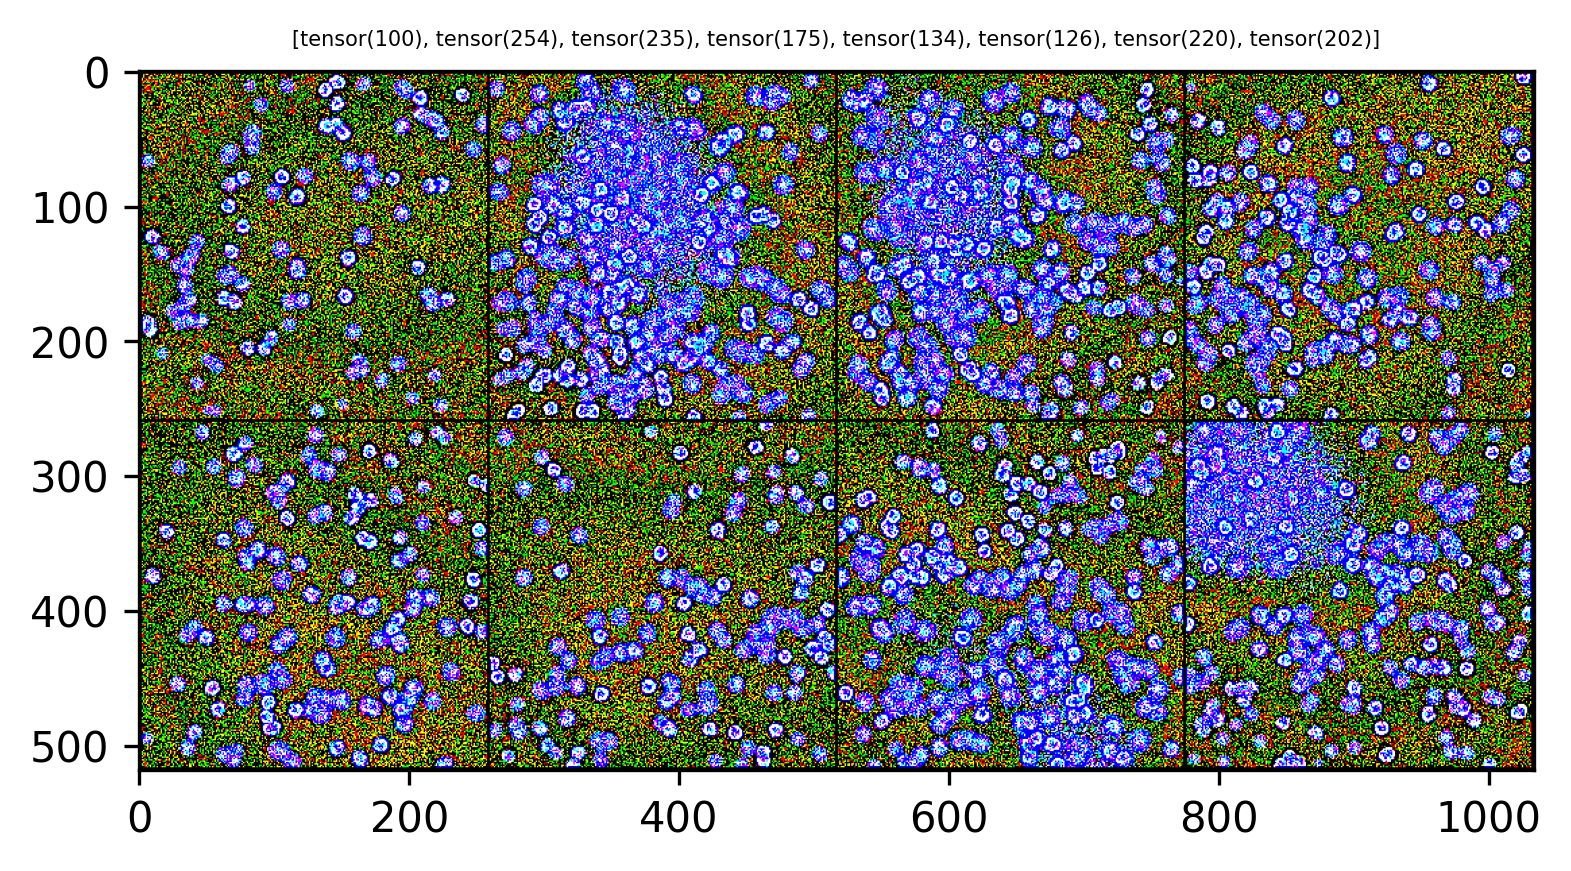

In [10]:
all_inputs = []
all_classes = []
while len(all_inputs) < 8:
    inputs, classes = next(iter(dataloaders['train']))
    all_inputs += inputs
    all_classes += classes

out = torchvision.utils.make_grid(all_inputs, nrow=4)
imshow(out, all_classes)

## train_regression function

Defining a function to train the regression model

In [11]:
def plot_loss(train_loss, val_loss):
    """
    Plots the loss progression
    """
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='test')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show

In [18]:
def calc_val_loss(model, dloader):
    # Don't change grad
    model.eval()
    loss_list = []
    for vinputs, vlabels in dloader:
        vinputs = vinputs.to(DEVICE)
        vlabels = vlabels.to(vlabels).item()
        voutputs = model(vinputs.float()).item()
        vloss = np.abs(voutputs - vlabels)
        loss_list.append(vloss.item())
    loss_list = np.array(loss_list)
    mae = np.mean(loss_list)
    mse = np.mean(loss_list**2)

    # Back to changing
    model.train()
    return mse, mae

In [19]:
def train_regression(net, dataloaders, criterion, optimizer,scheduler=None, num_epochs=25, device=DEVICE):

    since = time.time()
    net.to(device)  # Move model to GPU
    # net.train()

    train_loss_list = []
    val_loss_list = []
    best_val_loss = np.inf

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        i = 0

        # # Add L2 regularization
        # l2_reg = 0.001
        # for param in net.parameters():
        #     criterion += l2_reg * torch.sum(torch.square(param))

        for inputs, labels in dataloaders['train']:
        #for i, data in enumerate(zip(train_data, train_targets)):
            inputs = inputs.to(device)
            labels = labels.to(device)  # Move data to GPU

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            inputs = inputs.float()
            outputs = net(inputs)

            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()

            if scheduler is not None:
              scheduler.step()
            # Print statistics
            running_loss += loss.item()

        train_loss = running_loss / 10
        print(f'Epoch: {epoch + 1} \ttrain loss: \t\t{train_loss:.3f}')
        val_mse, _ = calc_val_loss(net, dataloaders['val'])
        print(f'\t\tvalidation loss: \t{val_mse:.3f}')
        print()
        train_loss_list.append(train_loss)
        val_loss_list.append(val_mse)

        # Keep the results of the best model so far
        if val_mse < best_val_loss:
            best_val_loss = val_mse
            # deepcopy the model
            best_model_wts = copy.deepcopy(net.state_dict())

    print('Finished Training')
    print('Best validation loss:', best_val_loss)

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')


    # load best model weights
    net.load_state_dict(best_model_wts)

    return net, train_loss_list, val_loss_list

# Models

### NN 1

Defining the NeuaralNetwork class

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # For CIFAR - 3 input channels
            nn.Conv2d(3, 32, (3,3)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3)),
            nn.ReLU(),
            nn.Conv2d(64, 128, (3,3)),
            nn.ReLU(),
            nn.Flatten(),
            # CIFAR input is 256*256, and 6 pixels were removed in the 3 Conv layers
            nn.Linear(128*(256-6)*(256-6), 1)
        )

    def forward(self, x):
        return self.model(x)

Training the NeuralNetwork model

In [21]:
# Creating an object
net = NeuralNetwork()

# Define the loss function
criterion = nn.MSELoss()
# criterion = nn.L1Loss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define the number of epochs
epochs = 10

net, train_loss, val_loss = train_regression(net, dataloaders,criterion, optimizer,scheduler=exp_scheduler,num_epochs = epochs)

Epoch: 1 	train loss: 		936124.727
		validation loss: 	31986.660

Epoch: 2 	train loss: 		610121.189
		validation loss: 	31986.660

Epoch: 3 	train loss: 		610121.189
		validation loss: 	31986.660

Epoch: 4 	train loss: 		610121.189
		validation loss: 	31986.660

Epoch: 5 	train loss: 		610121.189
		validation loss: 	31986.660

Epoch: 6 	train loss: 		610121.189
		validation loss: 	31986.660

Epoch: 7 	train loss: 		610121.189
		validation loss: 	31986.660

Epoch: 8 	train loss: 		610121.189
		validation loss: 	31986.660

Epoch: 9 	train loss: 		610121.189
		validation loss: 	31986.660

Epoch: 10 	train loss: 		610121.189
		validation loss: 	31986.660

Finished Training
Best validation loss: 31986.660410953435
Training complete in 0m 12s


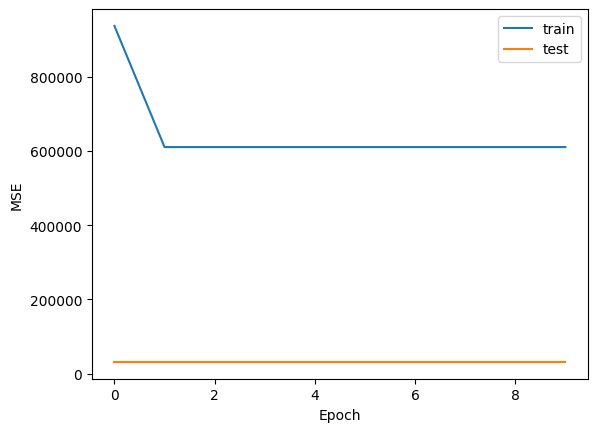

In [22]:
plot_loss(train_loss, val_loss)

We can see that the network doesn't learn for the second epoch. We will test the network results:

Calculating the MAE for the validation set

In [23]:
for inputs, labels in dataloaders['val']:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  outputs = net(inputs.to(device).float())
  mae = (labels.cpu().numpy()-outputs.int().cpu().numpy()).mean()
  print('labels:', labels.cpu().numpy())
  print('predic:', outputs.int().cpu().numpy().T)
  print(f'MAE = {mae}')
  print('-'*15)
# # labels


labels: [292]
predic: [[3]]
MAE = 289.0
---------------
labels: [98]
predic: [[5]]
MAE = 93.0
---------------
labels: [244]
predic: [[3]]
MAE = 241.0
---------------
labels: [132]
predic: [[15]]
MAE = 117.0
---------------
labels: [86]
predic: [[19]]
MAE = 67.0
---------------
labels: [273]
predic: [[-9]]
MAE = 282.0
---------------
labels: [224]
predic: [[-3]]
MAE = 227.0
---------------
labels: [218]
predic: [[-4]]
MAE = 222.0
---------------
labels: [95]
predic: [[19]]
MAE = 76.0
---------------
labels: [248]
predic: [[12]]
MAE = 236.0
---------------
labels: [156]
predic: [[16]]
MAE = 140.0
---------------
labels: [79]
predic: [[10]]
MAE = 69.0
---------------
labels: [153]
predic: [[16]]
MAE = 137.0
---------------
labels: [200]
predic: [[-3]]
MAE = 203.0
---------------
labels: [200]
predic: [[4]]
MAE = 196.0
---------------
labels: [218]
predic: [[-6]]
MAE = 224.0
---------------
labels: [128]
predic: [[9]]
MAE = 119.0
---------------
labels: [124]
predic: [[0]]
MAE = 124.0
----

In [24]:
mse, mae = calc_val_loss(net, dataloaders['val'])
print('MSE:', mse, 'MAE', mae)

MSE: 31986.660410953435 MAE 164.0444888755679


We can see that the model's performance is far from good. We will define a second model

## NN 2

Defining a second network

In [28]:
class NeuralNetwork_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # For CIFAR - 3 input channels
            nn.Conv2d(3, 32, (3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # The dimensions become 2 times smaller
            nn.Conv2d(32, 64, (3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, (3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # The dimensions become 2 times smaller
            nn.Conv2d(128, 256, (3,3), padding=1),
            nn.ReLU(),
            nn.Flatten(),
            # Input is 256 X 256, using 3 max-pooling
            nn.Linear(256*(256//2//2//2)*(256//2//2//2), 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.model(x)

In [29]:
model_2 = NeuralNetwork_2()
summary(model_2.to(DEVICE), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
              ReLU-8          [-1, 128, 64, 64]               0
         MaxPool2d-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]         295,168
             ReLU-11          [-1, 256, 32, 32]               0
          Flatten-12               [-1, 262144]               0
           Linear-13                  [-1, 128]      33,554,560
             ReLU-14                  [

training the NeuralNetwork_2 network

In [30]:
# Inatiate the network

net_2 = NeuralNetwork_2()

# Define the loss function
criterion = nn.MSELoss()
# criterion = nn.L1Loss()

# Define the optimizer
optimizer = optim.Adam(net_2.parameters(), lr=0.001)

# exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define the number of epochs
epochs = 20

net_2, train_loss, val_loss = train_regression(net_2,dataloaders,criterion, optimizer,num_epochs = epochs)

Epoch: 1 	train loss: 		58702.044
		validation loss: 	383.520

Epoch: 2 	train loss: 		5779.057
		validation loss: 	778.857

Epoch: 3 	train loss: 		6543.986
		validation loss: 	613.992

Epoch: 4 	train loss: 		8314.997
		validation loss: 	220.221

Epoch: 5 	train loss: 		4183.780
		validation loss: 	95.032

Epoch: 6 	train loss: 		6693.309
		validation loss: 	131.460

Epoch: 7 	train loss: 		5078.062
		validation loss: 	401.912

Epoch: 8 	train loss: 		5721.876
		validation loss: 	1874.322

Epoch: 9 	train loss: 		6093.930
		validation loss: 	751.327

Epoch: 10 	train loss: 		5892.221
		validation loss: 	2422.545

Epoch: 11 	train loss: 		7052.581
		validation loss: 	77.062

Epoch: 12 	train loss: 		1621.673
		validation loss: 	120.119

Epoch: 13 	train loss: 		1700.120
		validation loss: 	58.326

Epoch: 14 	train loss: 		2192.162
		validation loss: 	58.413

Epoch: 15 	train loss: 		2947.853
		validation loss: 	341.485

Epoch: 16 	train loss: 		2433.566
		validation loss: 	49.342

Epo

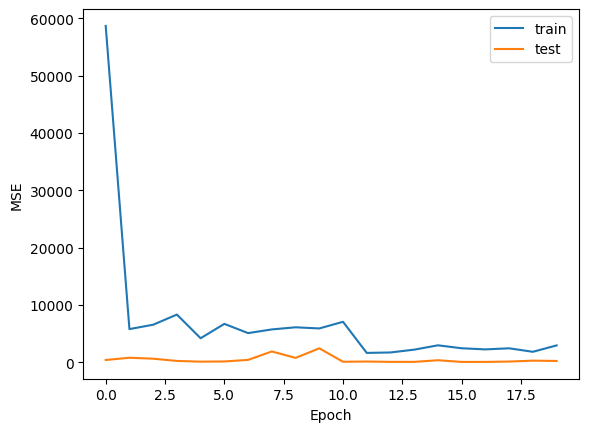

In [31]:
plot_loss(train_loss, val_loss)

In [32]:
for x in ['train','val']:
  loss_list = []
  for inputs, labels in dataloaders[x]:
      outputs = net_2(inputs.cuda().float())
      loss = np.abs(outputs.detach().cpu().numpy() - labels.detach().cpu().numpy())
      loss_list.append(loss.item())
  print(f'Stage: {x}')
  print('loss:', loss_list)
  print('MAE:', np.mean(loss_list))
  print('-'*15)

Stage: train
loss: [7.728485107421875, 0.4149627685546875, 1.33740234375, 1.221710205078125, 0.6539154052734375, 1.0219573974609375, 5.115814208984375, 0.399658203125, 8.077117919921875, 2.60223388671875, 2.8752288818359375, 8.56646728515625, 4.4652862548828125, 0.27252197265625, 2.78900146484375, 0.6946868896484375, 0.5882720947265625, 5.5230865478515625, 5.4241180419921875, 2.9952545166015625, 5.178009033203125, 0.299407958984375, 1.334564208984375, 3.213958740234375, 0.830078125, 3.2703857421875, 8.701095581054688, 1.25469970703125, 4.309730529785156, 3.0880355834960938, 4.397796630859375, 1.1770477294921875, 0.117889404296875, 2.017852783203125, 2.2051544189453125, 1.5304946899414062, 1.33502197265625, 1.7068634033203125, 0.181640625, 2.06640625, 3.678741455078125, 3.293975830078125, 5.13812255859375, 2.759429931640625, 1.4936065673828125, 0.073883056640625, 1.3332672119140625, 1.2730865478515625, 0.25836181640625, 4.32574462890625, 3.3389968872070312, 10.151504516601562, 4.1959991

## vgg16

In [33]:
# Inatiate the network
# net = NeuralNetwork()
model_vgg = models.vgg16(pretrained=True)
model_vgg.classifier[3] = nn.Linear(in_features=4096, out_features=1000)
model_vgg.classifier[6] = nn.Linear(in_features=1000, out_features=1)

# Define the loss function
criterion = nn.MSELoss()
# criterion = nn.L1Loss()

# Define the optimizer
optimizer = optim.Adam(model_vgg.parameters(), lr=0.001)

# Define the number of epochs
epochs = 10

model_vgg, train_loss, val_loss = train_regression(model_vgg,dataloaders,criterion, optimizer,num_epochs = epochs)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 147MB/s] 


Epoch: 1 	train loss: 		179163.738
		validation loss: 	2449.135

Epoch: 2 	train loss: 		429459.140
		validation loss: 	3495.501

Epoch: 3 	train loss: 		408316.792
		validation loss: 	25586.948

Epoch: 4 	train loss: 		467407.373
		validation loss: 	2920.216

Epoch: 5 	train loss: 		486711.831
		validation loss: 	4174.380

Epoch: 6 	train loss: 		211671.895
		validation loss: 	4393.436

Epoch: 7 	train loss: 		135633.327
		validation loss: 	3983.981

Epoch: 8 	train loss: 		137529.885
		validation loss: 	4713.197

Epoch: 9 	train loss: 		109451.496
		validation loss: 	6384.766

Epoch: 10 	train loss: 		132895.988
		validation loss: 	6133.362

Finished Training
Best validation loss: 2449.134886809169
Training complete in 0m 43s


In [34]:
for x in ['train','val']:
  loss_list = []
  for inputs, labels in dataloaders[x]:
      outputs = model_vgg(inputs.cuda().float())
      loss = np.abs(outputs.detach().cpu().numpy() - labels.detach().cpu().numpy())
      loss_list.append(loss.item())
  print(f'Stage: {x}')
  print('loss:', loss_list)
  print('MAE:', np.mean(loss_list))
  print('-'*15)

Stage: train
loss: [75.04638671875, 26.450969696044922, 69.49905395507812, 21.657867431640625, 51.7425537109375, 130.71434783935547, 30.615764617919922, 61.11579895019531, 78.50424194335938, 74.57859802246094, 62.581085205078125, 38.29975891113281, 26.286659240722656, 22.42101287841797, 87.62336730957031, 31.234664916992188, 81.17147827148438, 11.044631958007812, 20.406085968017578, 52.78999328613281, 5.712890625, 40.282493591308594, 61.821563720703125, 39.247467041015625, 54.4697265625, 28.154861450195312, 108.24571228027344, 65.40925598144531, 42.3834228515625, 35.47393798828125, 68.06465148925781, 92.57138061523438, 27.970985412597656, 33.82646179199219, 12.368335723876953, 77.34701538085938, 53.35731506347656, 74.445068359375, 28.944625854492188, 47.26904296875, 56.52961730957031, 51.342529296875, 19.318557739257812, 34.1982421875, 76.85719299316406, 30.653228759765625, 74.92257690429688, 65.54014587402344, 58.80475616455078, 47.3802490234375, 71.87301635742188, 121.83056640625, 58

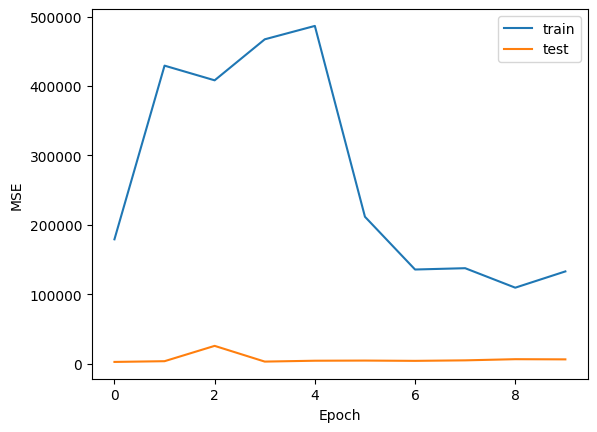

In [35]:
plot_loss(train_loss, val_loss)

It seems that **NueralNetwork_2** returned the best results.